# TCC
## Kevenn Henrique de Paula Silva - IFMG

## Redução de dimensionalidade em dados de clima com uso de *Stacked Autoencoder*

Neste trabalho, irá ser utilizado conjuntos de dados climáticos da cidade de Bambuí. Serão utilizados dados do ano de 2020 para treinar e validar o modelo e dados do ano de 2022 para realizar o teste do modelo, estes datasets estão disponíveis no [repositório de datasets do Instituto Nacional de Meteorologia](https://portal.inmet.gov.br/dadoshistoricos). Estes conjuntos de dados são multivariados, compostos por 17 atributos numéricos, onde posteriormente eles serão utilizados como a entrada do modelo:

1. PRECIPITAÇÃO
2. PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO
3. PRESSÃO ATMOSFERICA MAX
4. PRESSÃO ATMOSFERICA MIN
5. RADIACAO GLOBAL
6. TEMPERATURA DO AR - BULBO SECO
7. TEMPERATURA DO PONTO DE ORVALHO
8. TEMPERATURA MÁXIMA
9. TEMPERATURA MÍNIMA
10. TEMPERATURA ORVALHO MAX
11. TEMPERATURA ORVALHO MIN
12. UMIDADE REL, MAX
13. UMIDADE REL, MIN
14. UMIDADE RELATIVA DO AR
15. DIREÇÃO DO VENTO
16. RAJADA MAXIMA DO VENTO
17. VELOCIDADE DO VENTO

# 1 Preparação do ambiente

In [ ]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#importacao de bibliotecas

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#biblioteca para implementar uma barra de progresso
import progressbar

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model
tensorflow.keras.utils.pydot = pyd

# 2 Importações de dados

In [ ]:
#Dá permissão para acessar os arquivos no drive (Mounted in /content/drive)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Caminho para a pasta do projeto
path = "/content/drive/Othercomputers/Meu laptop/Kevenn.Pasta/SemestresDaFaculdade/TCC/Projetos em Python/Projetos Notebooks/SAE para climate_reconstruction/"

In [ ]:
#importacao dos dados de treino e validação
data_train_val = pd.read_csv(path + 'dataset/2020_climate_dataset.CSV', encoding='latin-1', delimiter=';', decimal=',')

x_names = data_train_val.columns[:].tolist()
y_names = data_train_val.columns[:].tolist()

data_train_val = data_train_val.astype(float)

In [ ]:
#importacao dos dados de teste
data_test = pd.read_csv(path + 'dataset/2022_climate_dataset.CSV', encoding='latin-1', delimiter=';', decimal=',')

data_test = data_test.astype(float)

In [ ]:
#vizualiza os dados em data_train_val
data_test

,PRECIPITAÇÃO,PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO,PRESSÃO ATMOSFERICA MAX,PRESSÃO ATMOSFERICA MIN,RADIACAO GLOBAL,TEMPERATURA DO AR - BULBO SECO,TEMPERATURA DO PONTO DE ORVALHO,TEMPERATURA MÁXIMA,TEMPERATURA MÍNIMA,TEMPERATURA ORVALHO MAX,TEMPERATURA ORVALHO MIN,"UMIDADE REL, MAX","UMIDADE REL, MIN",UMIDADE RELATIVA DO AR,DIREÇÃO DO VENTO,RAJADA MAXIMA DO VENTO,VELOCIDADE DO VENTO
0,0.0,932.4,932.4,931.5,NaN,20.6,20.4,20.8,20.6,20.4,20.4,99.0,98.0,99.0,30.0,5.1,2.3
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.2,933.1,933.2,933.0,NaN,20.4,20.4,20.4,20.3,20.4,20.3,100.0,100.0,100.0,45.0,4.0,2.1
3,0.8,932.6,933.1,932.6,NaN,20.1,20.0,20.4,20.1,20.4,20.0,100.0,99.0,99.0,44.0,8.6,3.8
4,1.6,932.3,932.6,932.3,NaN,19.5,19.5,20.1,19.5,20.0,19.5,100.0,99.0,100.0,52.0,7.0,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,935.7,935.9,935.6,1160.0,24.6,20.7,28.0,24.3,21.2,19.8,81.0,62.0,79.0,358.0,10.3,3.0
8756,0.0,935.3,935.7,935.2,745.2,24.6,21.0,24.8,24.2,21.2,20.2,81.0,76.0,80.0,26.0,6.4,1.2
8757,0.0,935.4,935.5,935.2,317.1,24.2,21.8,24.9,24.2,21.9,21.0,87.0,80.0,87.0,8.0,3.4,1.6
8758,0.0,936.0,936.0,935.4,67.3,23.7,21.6,24.4,23.7,22.2,21.2,90.0,82.0,88.0,127.0,2.6,0.2


# 3 Configurações do experimento

In [ ]:
#Tratar dados faltantes utilizados durante o treinamento e a validação (Realizar interpolacao nos dados de treinamento e validação)
interp_exec_train_val = True

#Tratar dados faltantes utilizados durante o teste (Realizar interpolacao nos dados de teste)
interp_exec_test = True

#-------------------------------------------------------------------------------
#realizar deteccao e substituicao dos outliers nos dados de treinamento e validação
outliers_exec = False

#-------------------------------------------------------------------------------
#realizar normalizacao nos dados de treinamento e validação
normalization_exec = False

#-------------------------------------------------------------------------------
#realizar escalonamento nos dados de treinamento e validação
scale_exec_train_val = True

#realizar escalonamento nos dados de treinamento e teste
scale_exec_test = True

#-------------------------------------------------------------------------------
#exportar os datasets tratados de treino e validação (True) ou usar um pronto (False)
export_frames_train_val = False

#exportar os datasets tratados de teste (True) ou usar um pronto (False)
export_frames_test = False

#-------------------------------------------------------------------------------
#gerar um novo modelo (True) ou usar um pronto (False)
new_model = False

# 4 Análise e tratamento de dados


## 4.1 Funções que serão utilizadas para realizar a análise e o tratamento dos dados

In [ ]:
#Função utilizada para realizar a sumarização estatística
def sumarizacao(data):
    stats = []

    for column in x_names:
        values = data[column]

        maximum = round(values.max(), 1)
        minimum = round(values.min(), 1)
        mean = round(values.mean(), 1)
        median = round(values.median(), 1)
        std = round(values.std(), 1)
        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)

#Função que plota o histograma de cada atributo
def plota_histograma(x_names,data):
    fig, axs = plt.subplots(6, 3, figsize=(16, 16), tight_layout=True)

    for i, atributo in enumerate(x_names):
        row = i // 3  # Linha atual
        col = i % 3   # Coluna atual
        axs[row, col].hist(data[atributo], bins=60)
        axs[row, col].set_title(atributo)
        axs[row, col].set_xlabel('Valores')
        axs[row, col].set_ylabel('Frequência')

    plt.show()

#Função que verificar dados faltantes
def dados_faltantes(data):
    missing_data_counts = data.isnull().sum()
    print("Total de dados faltantes por atributo:")
    print(missing_data_counts)

#Função que trata os dados faltantes
#interpola os dados com o cuidado de verificar os dados faltantes no inicio ou fim do atributo
def interpolacao(data):
    if data.isnull().values.any():
        outlier_inds_danger = [0, 1, len(data) - 2, len(data) - 1]
        for colname in x_names:
            for ind_danger in outlier_inds_danger:
                if np.isnan(data[colname].iloc[ind_danger].astype(float)):
                    data[colname].iloc[ind_danger] = data[colname].mean()

            data[colname] = data[colname].interpolate(method='nearest').copy()

    return data

#Função que plota o boxplot de cada atributo para verificar os outliers
def plota_boxplot(x_names, data):
    fig, axs = plt.subplots(6, 3, figsize=(16, 16), tight_layout=True)

    for i, atributo in enumerate(x_names):
        row = i // 3  # Linha atual
        col = i % 3   # Coluna atual
        axs[row, col].boxplot(data[atributo])
        axs[row, col].set_title(atributo)
        axs[row, col].set_xticks([])  # Remove os ticks do eixo x

    plt.show()

#Função para remover os outliers
def getQuantiles(x, margin = 1.5, low = 0.1, high = 0.9):
    q1 = x.quantile(low)
    q3 = x.quantile(high)
    iqr = q3-q1

    fence_low  = q1 - margin * iqr
    fence_high = q3 + margin * iqr

    return [fence_low, fence_high]

def replaceOutliers(serie, m):
    x = serie.copy()

    fences = getQuantiles(x, margin = m)

    bad_inds = x.loc[(x < fences[0]) | (x > fences[1])].index

    x[bad_inds] = np.nan

    outlier_inds_danger = [0, 1, len(serie) - 2, len(serie) - 1]

    for ind_danger in outlier_inds_danger:
        if np.isnan(x.iloc[ind_danger]):
            x[ind_danger] = (fences[0] + fences[1])/2

    if x.isnull().values.any():
        x = x.interpolate(method='nearest').copy()

    return x

#Função para normalizar os dados (estabilização de variância)
def varianceEstabilization(serie, method):
    if method == 'asinh':
        return np.arcsinh(serie)
    elif method == 'log':
        return np.log(serie)
    elif method == 'mean':
        return (serie - np.mean(serie))/np.std(serie)

#Funções utilizadas para escalonar
#funcao que cria uma regua com valores minimos e maximos para se usar no escalonamento
def create_support_col(minvalue, maxvalue, sizecol):
    minvalues = [minvalue] * round(sizecol/2)
    maxvalues = [maxvalue] * (sizecol - round(sizecol/2))
    return [*minvalues, *maxvalues]

def minMaxIndividual(df, col, minvalue, maxvalue, rgint):
    serie = df[col].copy()

    #cria uma regua com um valor minimo e um maximo previamente determinado
    serie['support'] = create_support_col(minvalue, maxvalue, len(serie))

    #escalona considerando o minimo e o maximo especificado
    tmp = serie.to_numpy().reshape(-1,1)

    minmaxscaler = preprocessing.MinMaxScaler(feature_range=rgint).fit(tmp)
    scaled = minmaxscaler.transform(tmp).reshape(serie.shape[0], serie.shape[1])

    #remove a coluna de suporte e atualiza as colunas ja escalonadas no dataset
    df[col] = scaled[:,0:(scaled.shape[1]-1)]

    return df

#Função que exporta ou carrega datasets tratados de treino, validação e teste
def exportando_carregando_dataset(data, x_names, y_names, pasta , bollean):
    if bollean == True:
        bar = progressbar.ProgressBar(maxval=len(data), widgets=[progressbar.Bar("=", "[", "]"), " ", progressbar.Percentage()])
        bar.start()

        x_frames= []
        y_frames = []

        cont = 0
        for ind in range(0, len(data), 1):
            x_frames.append(data.loc[ind, x_names].values)
            y_frames.append(data.loc[ind, y_names].values)

            bar.update(cont + 1)
            cont += 1

        x_frames = np.array(x_frames)
        y_frames = np.array(y_frames)

        dump(x_frames, path + 'dataset/x_frames' + pasta + '.joblib')
        dump(y_frames, path + 'dataset/y_frames' + pasta + '.joblib')

        bar.finish()
    else:
        x_frames = load(path + 'dataset/x_frames' + pasta + '.joblib')
        y_frames = load(path + 'dataset/y_frames' + pasta + '.joblib')

    print(x_frames.shape)
    print(y_frames.shape)

    return x_frames, y_frames

#Função que plota a curva de convergência do treinamento e da validação
def plot_curva_de_convergencia():
    history=np.load(path + 'models/history_model.npy', allow_pickle='TRUE').item()

    sns.set(rc={'figure.figsize':(12, 6)})
    sns.set_style('whitegrid')
    sns.set_context('paper')

    train_metric = history['loss']
    valid_metric = history['val_loss']
    name_metric = 'mean_squared_error'

    fig = plt.figure()

    plt.plot(train_metric, label='train'),
    plt.plot(valid_metric, label='validation')
    plt.ylabel(name_metric)
    plt.xlabel('epoch')
    plt.title('train vs. validation accuracy using ' + name_metric)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

    plt.show()

## 4.2 Análise inicial dos dados

### 4.2.1 Sumarização estatística

In [ ]:
sumarizacao(data_train_val)

| Coluna                                  |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------------------------------|---------:|---------:|--------:|----------:|----------------:|
| PRECIPITAÇÃO                            |     53   |      0   |     0.2 |       0   |             1.5 |
| PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO |    948.6 |    925.6 |   937.2 |     937   |             3.4 |
| PRESSÃO ATMOSFERICA MAX                 |    948.6 |    926   |   937.5 |     937.3 |             3.4 |
| PRESSÃO ATMOSFERICA MIN                 |    948.5 |    925.4 |   937   |     936.7 |             3.5 |
| RADIACAO GLOBAL                         |   4209.3 |      0   |  1420.2 |    1285.1 |          1102.9 |
| TEMPERATURA DO AR - BULBO SECO          |     38.1 |      4.4 |    21.1 |      21.2 |             5.6 |
| TEMPERATURA DO PONTO DE ORVALHO         |     23.6 |      2.8 |    16.5 |      17.4 |             4.1 |
| TEMPERATURA MÁXIMA                      |   

In [ ]:
sumarizacao(data_test)

| Coluna                                  |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------------------------------|---------:|---------:|--------:|----------:|----------------:|
| PRECIPITAÇÃO                            |     30.4 |      0   |     0.2 |       0   |             1.4 |
| PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO |    946.3 |    923.7 |   936.8 |     936.7 |             3.3 |
| PRESSÃO ATMOSFERICA MAX                 |    946.3 |    924.2 |   937.1 |     937   |             3.3 |
| PRESSÃO ATMOSFERICA MIN                 |    946   |    923.7 |   936.5 |     936.4 |             3.3 |
| RADIACAO GLOBAL                         |   4056.3 |      0   |  1444.4 |    1322.5 |          1100.7 |
| TEMPERATURA DO AR - BULBO SECO          |     35.9 |      3.8 |    20.7 |      20.8 |             5.8 |
| TEMPERATURA DO PONTO DE ORVALHO         |     23.7 |     -1.2 |    16   |      17.1 |             4.3 |
| TEMPERATURA MÁXIMA                      |   

###4.2.2 Plota o histograma de cada atributo

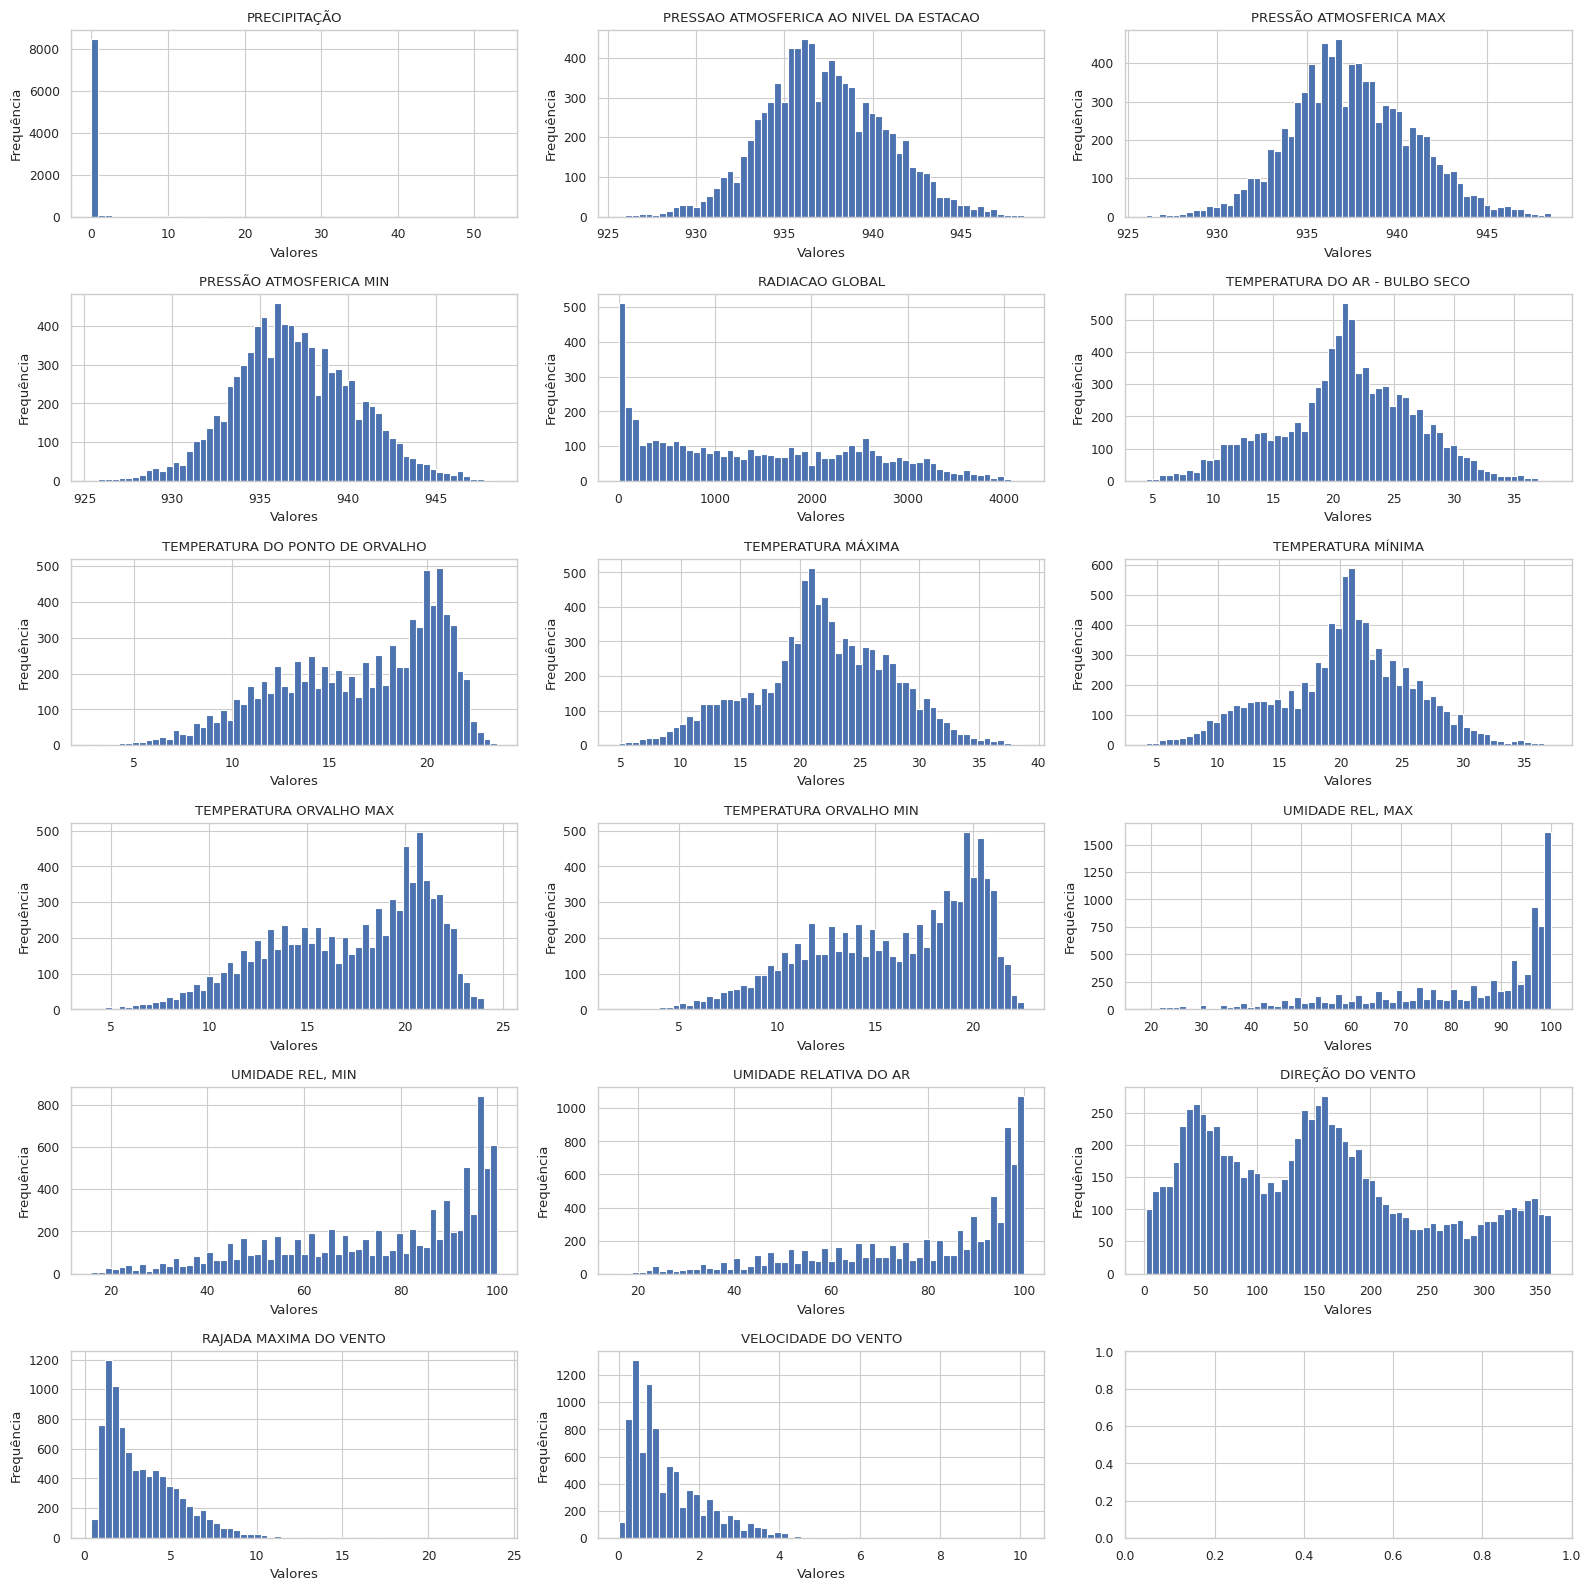

In [ ]:
plota_histograma(x_names, data_train_val)

## 4.3 Verificando e tratando dados faltantes com a interpolação

###4.3.1 Verificando dados faltantes

In [ ]:
if interp_exec_train_val:
    dados_faltantes(data_train_val)

Total de dados faltantes por atributo:
PRECIPITAÇÃO                                 34
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO      34
PRESSÃO ATMOSFERICA MAX                      34
PRESSÃO ATMOSFERICA MIN                      34
RADIACAO GLOBAL                            4082
TEMPERATURA DO AR - BULBO SECO               34
TEMPERATURA DO PONTO DE ORVALHO              34
TEMPERATURA MÁXIMA                           34
TEMPERATURA MÍNIMA                           34
TEMPERATURA ORVALHO MAX                      34
TEMPERATURA ORVALHO MIN                      34
UMIDADE REL, MAX                             34
UMIDADE REL, MIN                             34
UMIDADE RELATIVA DO AR                       34
DIREÇÃO DO VENTO                             71
RAJADA MAXIMA DO VENTO                       35
VELOCIDADE DO VENTO                          35
dtype: int64


In [ ]:
if interp_exec_test:
    dados_faltantes(data_test)

Total de dados faltantes por atributo:
PRECIPITAÇÃO                                168
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO     168
PRESSÃO ATMOSFERICA MAX                     168
PRESSÃO ATMOSFERICA MIN                     168
RADIACAO GLOBAL                            4090
TEMPERATURA DO AR - BULBO SECO              168
TEMPERATURA DO PONTO DE ORVALHO             168
TEMPERATURA MÁXIMA                          168
TEMPERATURA MÍNIMA                          168
TEMPERATURA ORVALHO MAX                     168
TEMPERATURA ORVALHO MIN                     168
UMIDADE REL, MAX                            168
UMIDADE REL, MIN                            168
UMIDADE RELATIVA DO AR                      168
DIREÇÃO DO VENTO                            196
RAJADA MAXIMA DO VENTO                      168
VELOCIDADE DO VENTO                         169
dtype: int64


###4.3.2  Tratando dados faltantes

In [ ]:
if interp_exec_train_val:
    data_train_val = interpolacao(data_train_val)

In [ ]:
if interp_exec_test:
    data_test = interpolacao(data_test)

###4.3.3 Verificando o dataset após a interpolação

In [ ]:
    data_train_val

,PRECIPITAÇÃO,PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO,PRESSÃO ATMOSFERICA MAX,PRESSÃO ATMOSFERICA MIN,RADIACAO GLOBAL,TEMPERATURA DO AR - BULBO SECO,TEMPERATURA DO PONTO DE ORVALHO,TEMPERATURA MÁXIMA,TEMPERATURA MÍNIMA,TEMPERATURA ORVALHO MAX,TEMPERATURA ORVALHO MIN,"UMIDADE REL, MAX","UMIDADE REL, MIN",UMIDADE RELATIVA DO AR,DIREÇÃO DO VENTO,RAJADA MAXIMA DO VENTO,VELOCIDADE DO VENTO
0,0.0,932.3,932.3,931.4,1420.219268,22.2,20.3,23.6,22.1,20.8,20.3,90.0,83.0,89.0,156.0,2.2,0.9
1,0.0,932.9,932.9,932.3,1420.219268,22.3,20.6,22.5,21.9,20.8,20.3,92.0,88.0,90.0,86.0,1.6,0.5
2,0.0,933.1,933.2,932.8,1420.219268,21.7,20.4,22.3,21.5,20.6,20.3,94.0,90.0,93.0,115.0,2.0,0.6
3,0.0,932.8,933.1,932.8,1420.219268,21.2,20.1,21.7,21.1,20.4,20.1,94.0,93.0,94.0,131.0,1.7,0.9
4,0.0,932.6,932.8,932.5,1420.219268,20.5,19.7,21.3,20.5,20.3,19.7,95.0,93.0,95.0,104.0,1.6,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,0.0,933.4,934.0,933.4,2671.000000,30.3,19.2,31.3,30.0,21.1,18.6,56.0,49.0,51.0,152.0,4.3,1.9
8780,0.0,933.6,933.6,933.2,1580.100000,30.6,18.6,31.3,30.3,19.9,18.0,53.0,48.0,49.0,296.0,3.8,1.0
8781,0.0,934.0,934.0,933.6,766.300000,29.0,19.3,31.6,29.0,19.3,18.2,56.0,46.0,56.0,207.0,2.5,1.1
8782,0.0,934.5,934.5,934.0,30.400000,25.7,20.9,29.0,25.7,21.1,19.3,76.0,56.0,75.0,160.0,2.3,0.7


###4.3.4 Verificando novamente os dados faltantes após a interpolação dos dados


In [ ]:
if interp_exec_train_val:
    dados_faltantes(data_train_val)

Total de dados faltantes por atributo:
PRECIPITAÇÃO                               0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO    0
PRESSÃO ATMOSFERICA MAX                    0
PRESSÃO ATMOSFERICA MIN                    0
RADIACAO GLOBAL                            0
TEMPERATURA DO AR - BULBO SECO             0
TEMPERATURA DO PONTO DE ORVALHO            0
TEMPERATURA MÁXIMA                         0
TEMPERATURA MÍNIMA                         0
TEMPERATURA ORVALHO MAX                    0
TEMPERATURA ORVALHO MIN                    0
UMIDADE REL, MAX                           0
UMIDADE REL, MIN                           0
UMIDADE RELATIVA DO AR                     0
DIREÇÃO DO VENTO                           0
RAJADA MAXIMA DO VENTO                     0
VELOCIDADE DO VENTO                        0
dtype: int64


### 4.3.5 Plota o histograma de cada atributo após a interpolação

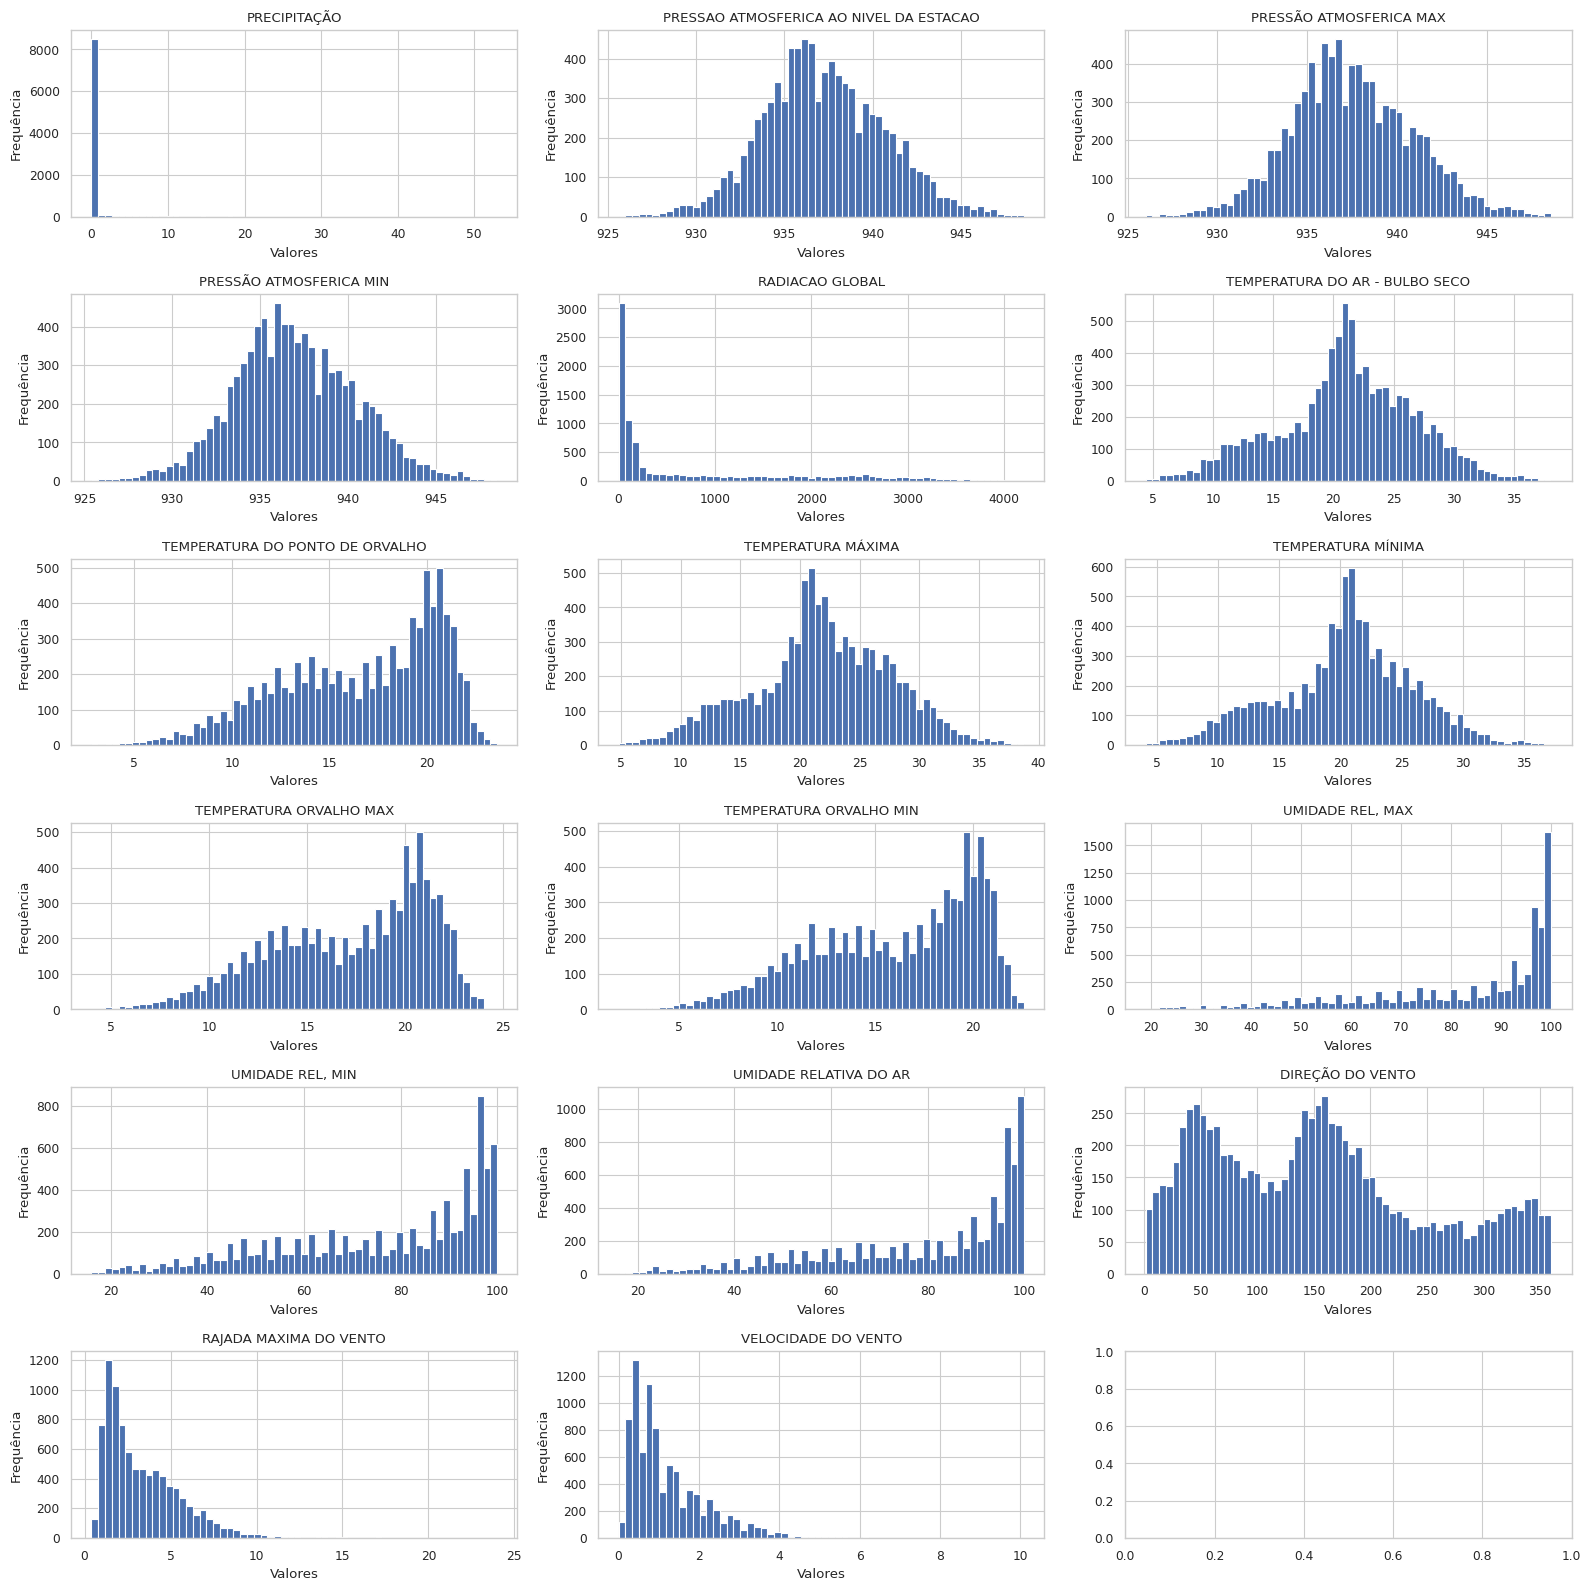

In [ ]:
if interp_exec_train_val:
    plota_histograma(x_names, data_train_val)

## 4.4 Verificando e removendo dados outliers

### 4.4.1 Plotando o boxplot de cada atributo para verificar os outliers

In [ ]:
if outliers_exec:
    plota_boxplot(x_names, data_train_val)

### 4.4.2 Removendo outliers

In [ ]:
if outliers_exec:
    for col in x_names:
        data_train_val[col] = replaceOutliers(data_train_val[col], 0)

###4.4.3 Plotando novamente o boxplot de cada atributo após remover os outliers

In [ ]:
if outliers_exec:
    plota_boxplot(x_names, data_train_val)

###4.3.4 Verificando os dados através do histograma de cada atributo após remover os outliers

In [ ]:
if outliers_exec:
    plota_histograma(x_names, data_train_val)

###4.4.5 Verificando os dados através da sumarização

In [ ]:
if outliers_exec:
    sumarizacao(data_train_val)

##4.5 Aplicando normalizacao (estabilização de variância)

In [ ]:
if normalization_exec:
    for col in x_names:
        data_train_val[col] = varianceEstabilization(data_train_val[col], 'mean')

In [ ]:
if normalization_exec:
    data_train_val

###4.5.1 Plotando histograma após a normalização

In [ ]:
if normalization_exec:
    plota_histograma(x_names, data_train_val)

## 4.6 Aplicando o escalonamento dos dados (padronização)

###4.6.1 Verificando os dados antes de escalonar

In [ ]:
if scale_exec_test:
    data_train_val

###4.6.2 Aplicando escalonamento

In [ ]:
if scale_exec_train_val:
    rangeinterval = (0, 1)

    for col in x_names:
        data_train_val = minMaxIndividual(data_train_val, [col], np.min(data_train_val[col]), np.max(data_train_val[col]), rangeinterval)

In [ ]:
if scale_exec_test:
    rangeinterval = (0, 1)

    for col in x_names:
        data_test = minMaxIndividual(data_test, [col], np.min(data_test[col]), np.max(data_test[col]), rangeinterval)

###4.6.3 Verificando os dados após o escalonamento

In [ ]:
if scale_exec_test:
    data_train_val

###4.6.4 Verificando os dados através da sumarização

In [ ]:
if scale_exec_test:
    sumarizacao(data_train_val)

| Coluna                                  |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------------------------------|---------:|---------:|--------:|----------:|----------------:|
| PRECIPITAÇÃO                            |        1 |        0 |     0   |       0   |             0   |
| PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO |        1 |        0 |     0.5 |       0.5 |             0.1 |
| PRESSÃO ATMOSFERICA MAX                 |        1 |        0 |     0.5 |       0.5 |             0.2 |
| PRESSÃO ATMOSFERICA MIN                 |        1 |        0 |     0.5 |       0.5 |             0.1 |
| RADIACAO GLOBAL                         |        1 |        0 |     0.2 |       0   |             0.2 |
| TEMPERATURA DO AR - BULBO SECO          |        1 |        0 |     0.5 |       0.5 |             0.2 |
| TEMPERATURA DO PONTO DE ORVALHO         |        1 |        0 |     0.7 |       0.7 |             0.2 |
| TEMPERATURA MÁXIMA                      |   

###4.6.5 Verificando os dados através do histograma de cada atributo

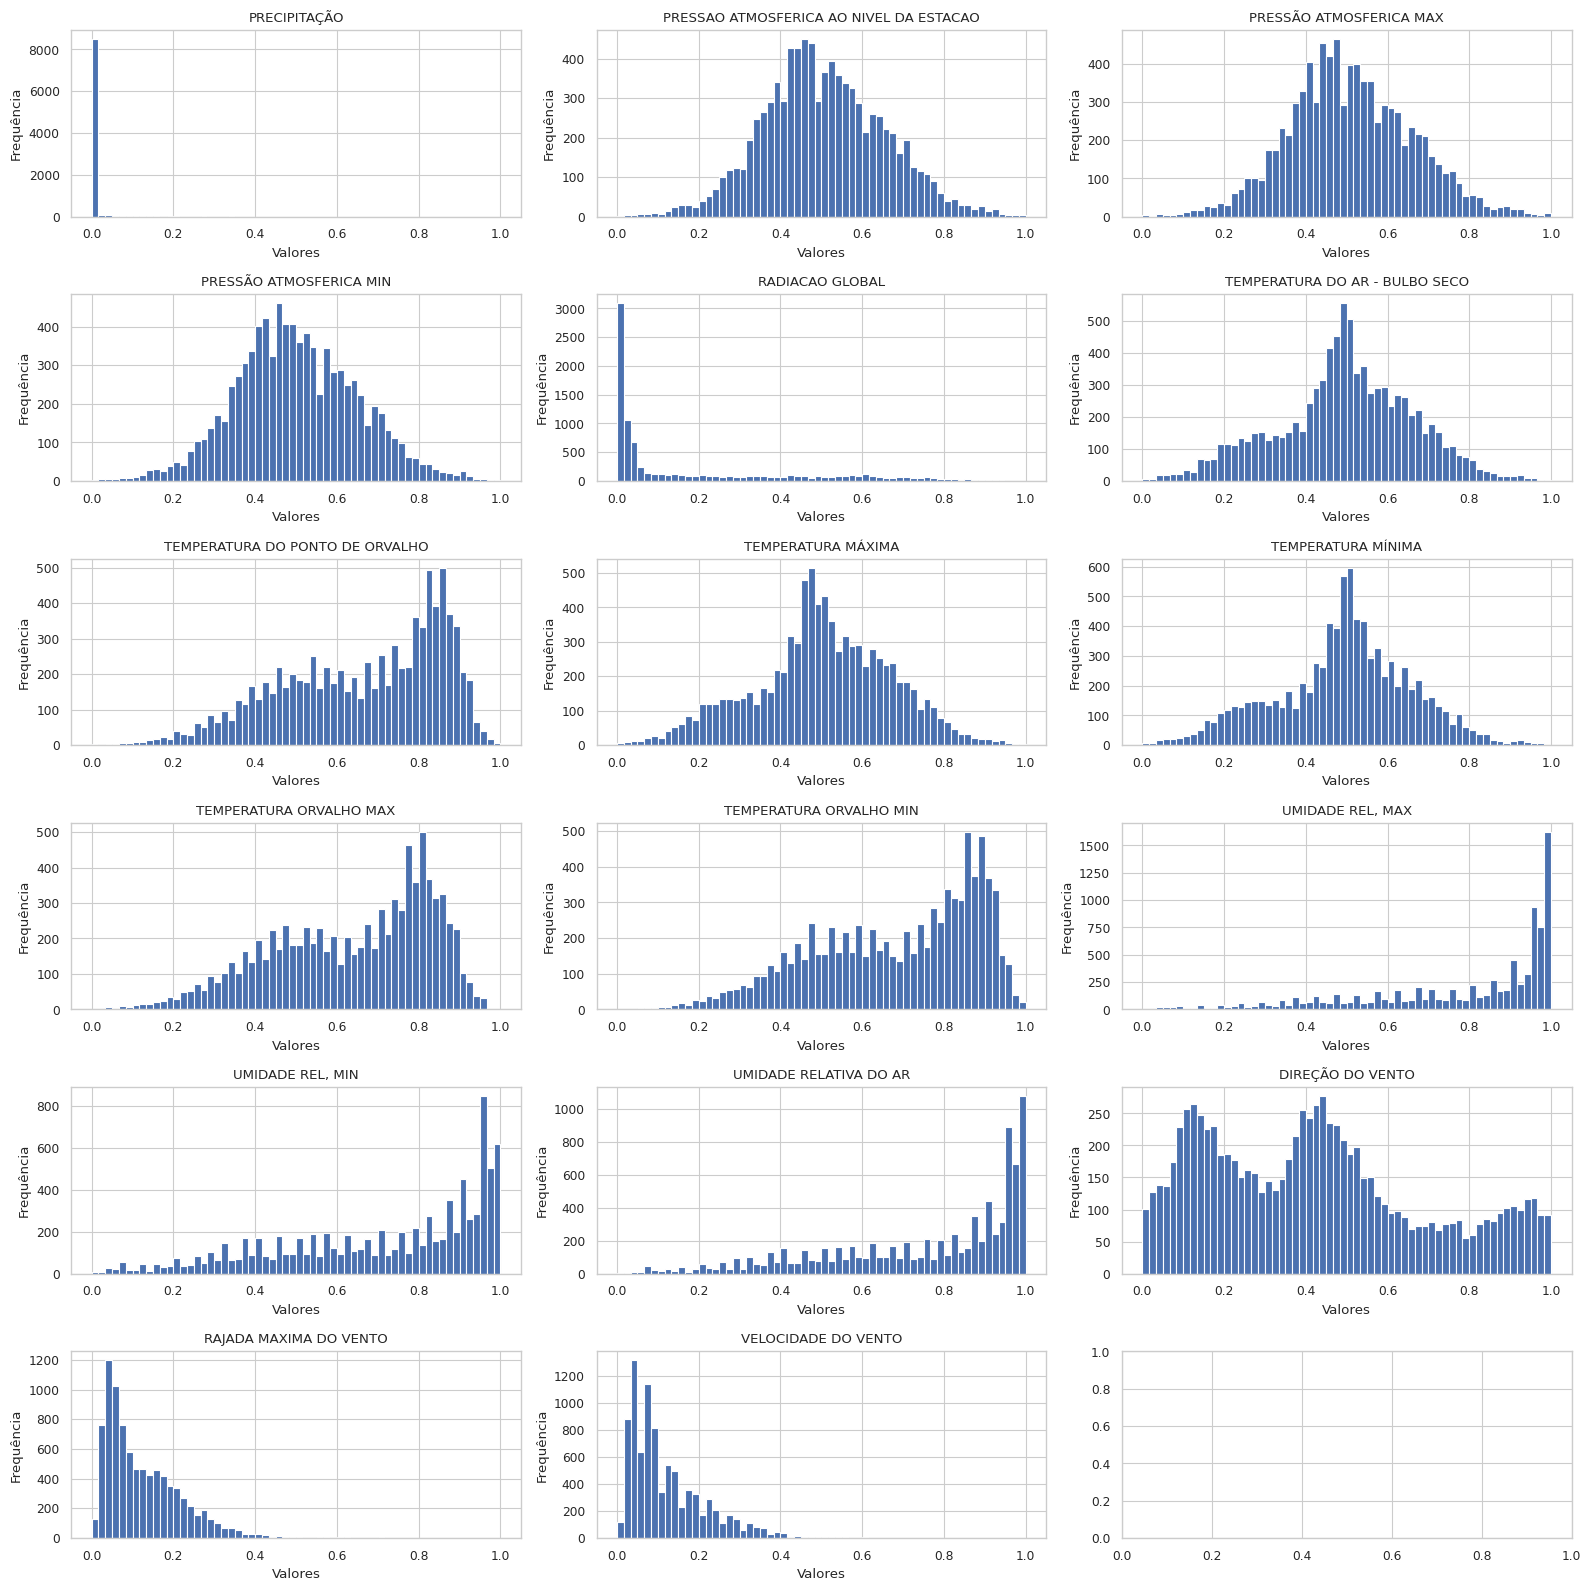

In [ ]:
if scale_exec_test:
    plota_histograma(x_names, data_train_val)

## 4.7 Exportando ou carregando *datasets* de treino, validação e teste

### 4.7.1 Exportando ou carregando o dataset tratado de treino e validação


In [ ]:
x_frames_train_val, y_frames_train_val = exportando_carregando_dataset(data_train_val, x_names, y_names, "_train_val" , export_frames_train_val)

(8784, 17)
(8784, 17)


### 4.7.2 Exportando ou carregando o dataset tratado de teste

In [ ]:
x_frames_test, y_frames_test = exportando_carregando_dataset(data_test, x_names, y_names, "_test" , export_frames_test)

(8760, 17)
(8760, 17)


# 5 Separacao dos conjuntos de dados (treino, validação e teste)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_frames_train_val, y_frames_train_val, test_size=0.3, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(6148, 17)
(6148, 17)
(2636, 17)
(2636, 17)


In [ ]:
x_test, y_test = x_frames_test, y_frames_test
print(x_test.shape)
print(y_test.shape)

(8760, 17)
(8760, 17)


# 6 Treinamento do modelo

## 6.1 Construção do modelo

In [ ]:
#Empilhamento de camadas para construir uma Deep Neural Network

act_function = 'sigmoid'
drop = 0.10
initializer = tensorflow.keras.initializers.LecunNormal(seed=33)

inputs = Input(shape = (x_train.shape[1]))

layer1 = Dense(16, activation=act_function, kernel_initializer=initializer)(inputs)
layer1 = Dropout(drop)(layer1)

layer2 = Dense(8, activation=act_function, kernel_initializer=initializer)(layer1)
layer2 = Dropout(drop)(layer2)

layer3 = Dense(6, activation=act_function, kernel_initializer=initializer)(layer2)
layer3 = Dropout(drop)(layer3)

layer4 = Dense(5, activation=act_function, kernel_initializer=initializer)(layer3)
layer4 = Dropout(drop)(layer4)

layer5 = Dense(6, activation=act_function, kernel_initializer=initializer)(layer4)
layer5 = Dropout(drop)(layer5)

layer6 = Dense(8, activation=act_function, kernel_initializer=initializer)(layer5)
layer6 = Dropout(drop)(layer6)

layer7 = Dense(16, activation=act_function, kernel_initializer=initializer)(layer6)
layer7 = Dropout(drop)(layer7)

outputs = Dense(y_train.shape[1], activation=act_function, kernel_initializer=initializer)(layer7)

#geracao do modelo
sae_climate_reconstruction = Model(inputs, outputs)

## 6.2 Inspecionando o modelo

In [ ]:
sae_climate_reconstruction.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_8 (Dense)             (None, 16)                288       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 6)                 54        
                                                                 
 dropout_9 (Dropout)         (None, 6)                 0   

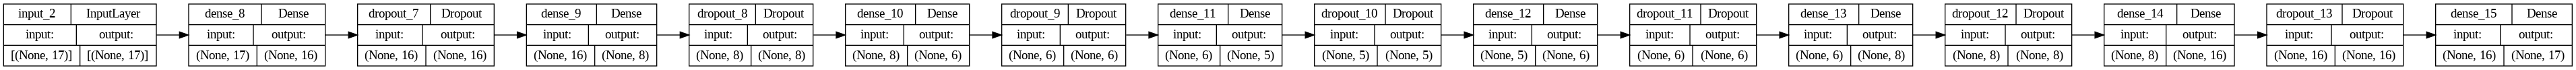

In [ ]:
plot_model(sae_climate_reconstruction, show_shapes=True, show_layer_names=True, rankdir="LR")

## 6.3 Otimização do modelo

In [ ]:
if (new_model == True):

    tensorflow.keras.backend.set_epsilon(1)
    opt = Adam(learning_rate=0.007)

    sae_climate_reconstruction.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

    cp = ModelCheckpoint(
    filepath= path + 'models/',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

    es = EarlyStopping(monitor='loss', mode='min', patience=100)

    history = sae_climate_reconstruction.fit(x_train, y_train,
                                validation_data=(x_val, y_val),
                                epochs=2000,
                                verbose=1,
                                callbacks=[es, cp],
                                batch_size=100,
                                shuffle=False)

    np.save(path + 'models/history_model.npy', history.history)
    sae_climate_reconstruction.load_weights(path + 'models/')
    sae_climate_reconstruction.save(path + 'models/sae_climate_reconstruction.h5')
else:
    sae_climate_reconstruction = load_model(path + 'models/sae_climate_reconstruction.h5')

## 6.4 Avaliação do modelo com curva de convergência

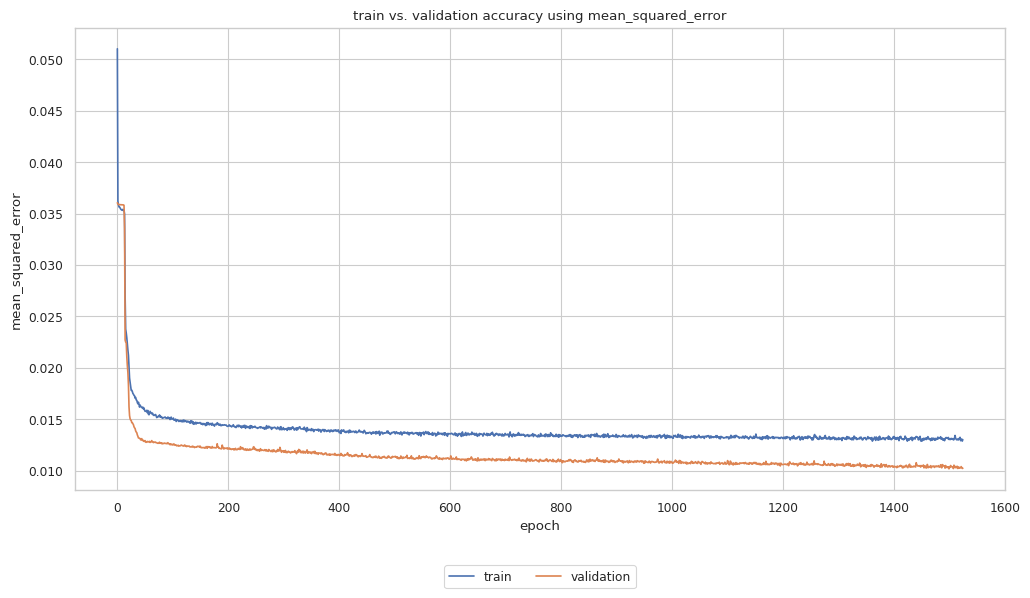

In [ ]:
plot_curva_de_convergencia()

# 7 Testando as previsões

## 7.1. Gerando as previsões com o modelo treinado

In [ ]:
y_hat = sae_climate_reconstruction.predict(x_test)

274/274 [==============================] - 0s 770us/step


## 7.2 Calculando o erro médio quadrático (MSE)


In [ ]:
# Calcular o erro médio quadrático (MSE)
mse = mean_squared_error(y_test, y_hat)

# Imprimi a métrica
print("Erro quadrático médio (MSE): ", mse)

Erro quadrático médio (MSE):  0.012018214020785374


In [ ]:
#Função que verifica a medida da soma total por atributo
def total_sum_measure(y_data, titles = x_names):
    summation  = []
    headers = []

    for i, atribute in enumerate(titles):
        sum = np.sum(y_data[i])
        summation.append([atribute, sum])

    table = tabulate(summation, tablefmt = "pipe")
    print(table)
    return summation
#Medida da soma total por atributo dos dados de esperados
print(" Medida da soma total por atributo dos dados de esperados")
summation1 = total_sum_measure(y_test)

#Medida da soma total por atributo dos dados previstos pela rede neural
print("\n Medida da soma total por atributo dos dados de previstos pela rede neural")
summation2 = total_sum_measure(y_hat)

 Medida da soma total por atributo dos dados de esperados
|:----------------------------------------|--------:|
| PRECIPITAÇÃO                            | 9.06604 |
| PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO | 8.62379 |
| PRESSÃO ATMOSFERICA MAX                 | 9.21286 |
| PRESSÃO ATMOSFERICA MIN                 | 9.42804 |
| RADIACAO GLOBAL                         | 9.29138 |
| TEMPERATURA DO AR - BULBO SECO          | 9.14445 |
| TEMPERATURA DO PONTO DE ORVALHO         | 8.59845 |
| TEMPERATURA MÁXIMA                      | 8.63282 |
| TEMPERATURA MÍNIMA                      | 8.6608  |
| TEMPERATURA ORVALHO MAX                 | 8.58049 |
| TEMPERATURA ORVALHO MIN                 | 8.80388 |
| UMIDADE REL, MAX                        | 9.17512 |
| UMIDADE REL, MIN                        | 9.31435 |
| UMIDADE RELATIVA DO AR                  | 9.28119 |
| DIREÇÃO DO VENTO                        | 9.55757 |
| RAJADA MAXIMA DO VENTO                  | 9.08618 |
| VELOCIDADE DO VENTO   

In [ ]:
#Medida da diferença total de cada atributo entre os dados esperados e os dados de previstos pela rede neural

headers = []

summation1_array = np.array(summation1)
summation2_array = np.array(summation2)

#regra de três
difference = (summation2_array[ : , 1].astype(float) * 100)/summation1_array[ : , 1 ].astype(float)

print("Medida da diferença total de cada atributo")
print(difference)

Medida da diferença total de cada atributo
[ 95.61894473  97.75273241  94.13554959  91.92616791  93.30887763
  94.82817566 101.16958887 100.79730168 100.4736113  101.3501603
  98.75769737  94.53735711  93.08664789  93.48340908  89.32637761
  93.90606701  92.54680459]


In [ ]:
#valores calcualdos anteriormente em forma de tabela com seus respectivos rótulos
summation2  = []
headers = []

for i, atribute in enumerate(x_names):
    value = difference[i]
    summation2.append([atribute, value])

table_by_attribute = tabulate(summation2, tablefmt = "pipe")
print(table_by_attribute)

|:----------------------------------------|---------:|
| PRECIPITAÇÃO                            |  95.6189 |
| PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO |  97.7527 |
| PRESSÃO ATMOSFERICA MAX                 |  94.1355 |
| PRESSÃO ATMOSFERICA MIN                 |  91.9262 |
| RADIACAO GLOBAL                         |  93.3089 |
| TEMPERATURA DO AR - BULBO SECO          |  94.8282 |
| TEMPERATURA DO PONTO DE ORVALHO         | 101.17   |
| TEMPERATURA MÁXIMA                      | 100.797  |
| TEMPERATURA MÍNIMA                      | 100.474  |
| TEMPERATURA ORVALHO MAX                 | 101.35   |
| TEMPERATURA ORVALHO MIN                 |  98.7577 |
| UMIDADE REL, MAX                        |  94.5374 |
| UMIDADE REL, MIN                        |  93.0866 |
| UMIDADE RELATIVA DO AR                  |  93.4834 |
| DIREÇÃO DO VENTO                        |  89.3264 |
| RAJADA MAXIMA DO VENTO                  |  93.9061 |
| VELOCIDADE DO VENTO                     |  92.5468 |
